In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.optimizers import Adam


# 1. Build a deep learning model for the dataset

In [10]:
#Data input
f_location = "https://drive.google.com/file/d/1abp6Oc3XLvN7x2l2r1RHMjWNwoCTanLV/view?usp=sharing"
data_raw = pd.read_csv('https://drive.google.com/uc?export=download&id=' + f_location.split('/')[-2]) #Convert to pandas DataFrames

target_subjects = ['ABE', 'AE', 'BIOE', 'CEE', 'CS', 'CSE', 'ECE', 'ENG', 'IE', 'ME', 'MSE', 'NPRE', 'PHYS', 'SE', 'TAM', 'TE']

grainger_data = data_raw[data_raw['Subject'].isin(target_subjects)].copy()

#Data preprocessing

# Calculate GPA using the provided formula
def calculate_gpa(row):
    grade_points = {
        # 'A+': 4.0, 'A': 4.0, 'A-': 3.7,
        # 'B+': 3.3, 'B': 3.0, 'B-': 2.7,
        # 'C+': 2.3, 'C': 2.0, 'C-': 1.7,
        # 'D+': 1.3, 'D': 1.0, 'D-': 0.7,
        # 'F': 0.0
        'A+': 4.00, 'A': 4.00, 'A-': 3.67,
        'B+': 3.33, 'B': 3.00, 'B-': 2.67,
        'C+': 2.33, 'C': 2.00, 'C-': 1.67,
        'D+': 1.33, 'D': 1.00, 'D-': 0.67,
        'F': 0.00
    }

    total_points = 0
    total_grades = 0

    for grade, points in grade_points.items():
        if grade in row:
            total_points += row[grade] * points
            total_grades += row[grade]
    if total_grades > 0:
        return total_points / total_grades
    else:
        return np.nan

#print(grainger_data)
# Add GPA column to the dataset
grainger_data['GPA'] = grainger_data.apply(calculate_gpa, axis=1)
grainger_data = grainger_data.drop(columns=['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W'])
#print(grainger_data)
# Drop rows with NaN GPA values
grainger_data = grainger_data.dropna(subset=['GPA'])



# Encode categorical features
label_encoders = {}
categorical_features = ['Subject', 'Course Title', 'Sched Type', 'Primary Instructor', 'Term', 'YearTerm']
for feature in categorical_features:
    le = LabelEncoder()
    grainger_data[feature] = le.fit_transform(grainger_data[feature])
    label_encoders[feature] = le

print(le)
# Split data into training/validation and test sets based on year
train_val_data = grainger_data[grainger_data['Year'] < 2023]
test_data = grainger_data[grainger_data['Year'] == 2023]

# Separate features and target variable
X_train_val = train_val_data.drop(columns=['GPA', 'Number', 'Year', 'Term',  'YearTerm'])
feature_names = X_train_val.columns.tolist()
y_train_val = train_val_data['GPA']
X_test = test_data.drop(columns=['GPA', 'Number', 'Year', 'Term',  'YearTerm'])
y_test = test_data['GPA']

print('test')
print(X_train_val)
print(y_train_val)


# Standardize numerical features
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

# Split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)



LabelEncoder()
test
       Subject  Course Title  Sched Type  Primary Instructor
2262         0           491           5                 105
2263         0           228           4                1147
2264         0           766           8                 246
2265         0           128           5                 977
2266         0           342           4                1118
...        ...           ...         ...                 ...
69030       11           975           5                 447
69031       11           973           5                 376
69066       13           550           5                 769
69067       13           554           4                 809
69068       13           551           5                 559

[9914 rows x 4 columns]
2262     3.872647
2263     3.463415
2264     3.924731
2265     3.305556
2266     3.899130
           ...   
69030    3.065686
69031    2.771316
69066    2.595714
69067    2.603333
69068    3.205641
Name: GPA, Length: 9914, 

Validation MSE: 0.05511031793434456
Training MSE: 0.02204189322590876


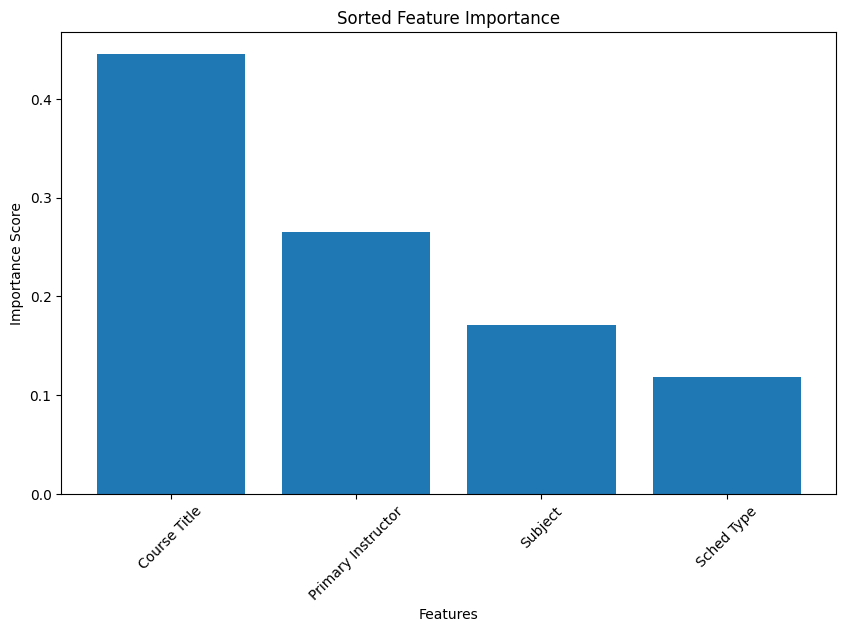

In [11]:
# Save the original feature column names

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
feature_importance = rf.feature_importances_
y_val_pred = rf.predict(X_val)
y_trian_pred = rf.predict(X_train)

# Calculate the MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) of the validation set
val_mse = mean_squared_error(y_val, y_val_pred)
train_mse = mean_squared_error(y_train, y_trian_pred)

print(f"Validation MSE: {val_mse}")
print(f"Training MSE: {train_mse}")
#print(train_val_data.columns.tolist())

sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importance = feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation=45)
plt.title("Sorted Feature Importance")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()


In [ ]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense

import tensorflow as tf

# Custom LearningRateSchedule to adjust learning rate based on epoch
class StepLearningRate(LearningRateSchedule):
    def __init__(self, initial_lr, drop_factor, step_size):
        self.initial_lr = initial_lr  # Initial Learning Rate
        self.drop_factor = drop_factor
        self.step_size = step_size  # Adjust the learning rate every `step_size` epochs
        self.epoch = 0

    def __call__(self, step):
        # Calculate the learning rate based on the epoch (decaying every `step_size` epochs)
        current_lr = self.initial_lr * (self.drop_factor ** (self.epoch // self.step_size))
        return tf.cast(current_lr, tf.float32)

    # Update the epoch count at the end of each epoch
    def update_epoch(self, epoch):
        self.epoch = epoch

# Create a StepLearningRate scheduler
initial_lr = 0.01
drop_factor = 0.1
step_size = 50
lr_schedule = StepLearningRate(initial_lr, drop_factor, step_size)

# Custom callback to update the epoch and print the learning rate
class UpdateEpochCallback(tf.keras.callbacks.Callback):
    def __init__(self, lr_schedule):
        super(UpdateEpochCallback, self).__init__()
        self.lr_schedule = lr_schedule

    def on_epoch_begin(self, epoch, logs=None):
        # update current epoch
        self.lr_schedule.update_epoch(epoch)
        # print current learning rate
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        print(f"\nEpoch {epoch + 1}: Learning rate is {lr:.6f}")

# Construct Model
model = tf.keras.Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(158, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=lr_schedule)  # Use the custom scheduler
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Initialize the callback
update_epoch_callback = UpdateEpochCallback(lr_schedule)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=[update_epoch_callback]
)

# Test the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")



Epoch 1: Learning rate is 0.010000
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


248/248 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 2.9426 - mae: 1.2222 - val_loss: 0.1637 - val_mae: 0.3369

Epoch 2: Learning rate is 0.010000
Epoch 2/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2428 - mae: 0.3921 - val_loss: 0.1502 - val_mae: 0.3212

Epoch 3: Learning rate is 0.010000
Epoch 3/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1934 - mae: 0.3568 - val_loss: 0.1445 - val_mae: 0.3138

Epoch 4: Learning rate is 0.010000
Epoch 4/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1884 - mae: 0.3532 - val_loss: 0.1415 - val_mae: 0.3102

Epoch 5: Learning rate is 0.010000
Epoch 5/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1806 - mae: 0.3453 - val_loss: 0.1411 - val_mae: 0.3082

Epoch 6: Learning rate is 0.010000
Epoch 6/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1753 - mae: 0.3402 - val_loss: 0.1437 - val_mae: 0.3072

Epoch 7: Learning rate is 0.010000
Epoch 7/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1725 - mae: 0.3367

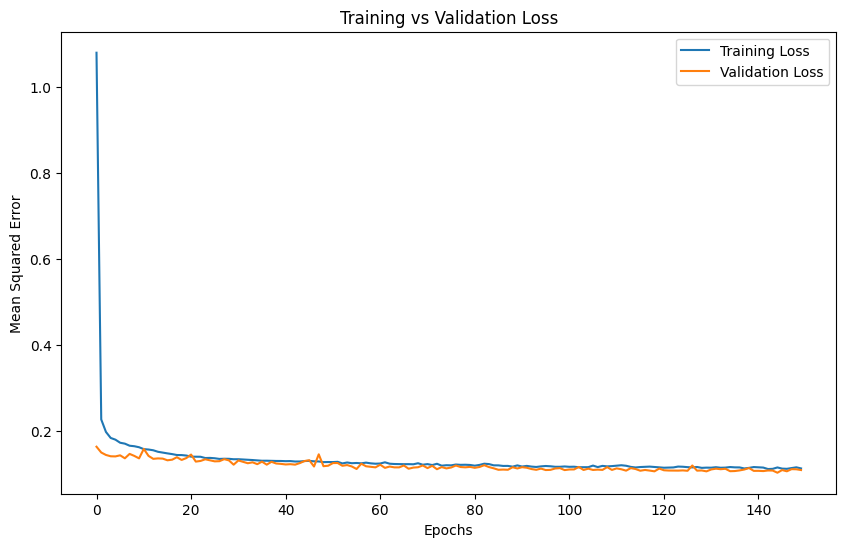

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


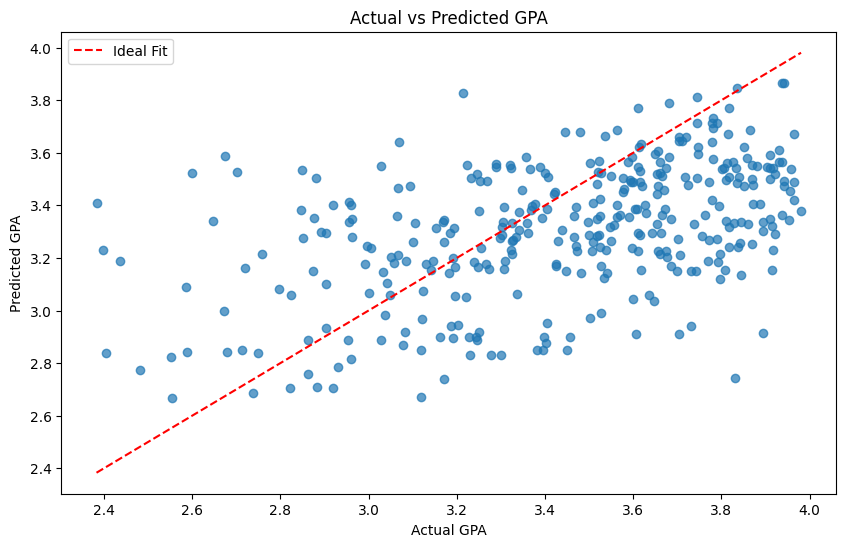

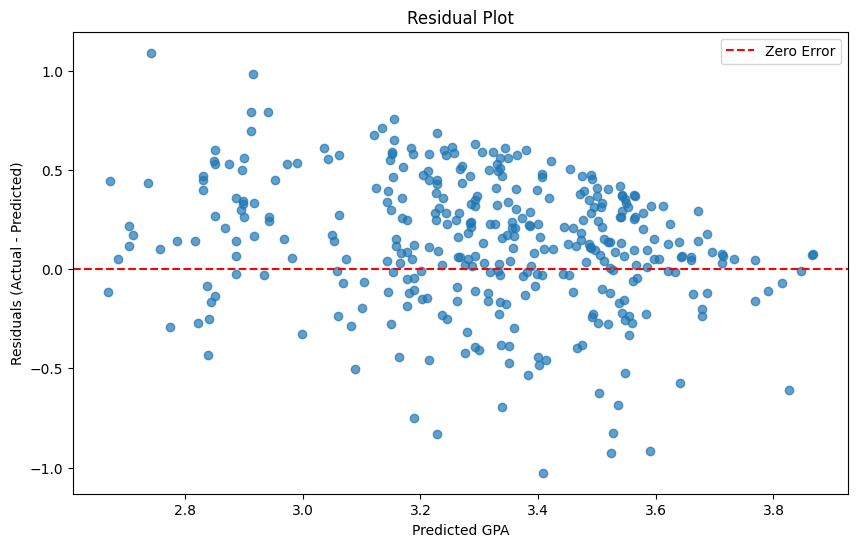

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Predict on the test set
y_pred = model.predict(X_test).flatten()

# Actual vs Predicted GPA
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title('Actual vs Predicted GPA')
plt.legend()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Predicted GPA')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.legend()
plt.show()

# 2. Investigate effects of mini-batch learning

In [21]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense

import tensorflow as tf

# Custom LearningRateSchedule to adjust learning rate based on epoch
class StepLearningRate(LearningRateSchedule):
    def __init__(self, initial_lr, drop_factor, step_size):
        self.initial_lr = initial_lr  # Initial Learning Rate
        self.drop_factor = drop_factor
        self.step_size = step_size  # Adjust the learning rate every `step_size` epochs
        self.epoch = 0

    def __call__(self, step):
        # Calculate the learning rate based on the epoch (decaying every `step_size` epochs)
        current_lr = self.initial_lr * (self.drop_factor ** (self.epoch // self.step_size))
        return tf.cast(current_lr, tf.float32)

    # Update the epoch count at the end of each epoch
    def update_epoch(self, epoch):
        self.epoch = epoch


# Create a StepLearningRate scheduler
initial_lr = 0.01
drop_factor = 0.1
step_size = 50
lr_schedule = StepLearningRate(initial_lr, drop_factor, step_size)
# Define batch sizes to test
batch_sizes = [4, 8, 16, 32, 64]

# To store results
results = []
model = tf.keras.Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(158, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=lr_schedule)  # Use the custom scheduler
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    # Train the model with the specified batch size
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,  # Use fewer epochs for faster experimentation
        batch_size=batch_size,
        verbose=0  # Suppress verbose output
    )

    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

    # Store results
    results.append({
        "batch_size": batch_size,
        "train_loss": history.history['loss'][-1],
        "val_loss": history.history['val_loss'][-1],
        "test_loss": test_loss,
        "test_mae": test_mae
    })







/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training with batch size: 4
Test Loss: 413154377728.0, Test MAE: 37704.1875

Training with batch size: 8
Test Loss: 35514248.0, Test MAE: 391.4033203125

Training with batch size: 16
Test Loss: 19568988160.0, Test MAE: 7509.92529296875

Training with batch size: 32
Test Loss: 930.6214599609375, Test MAE: 1.9077496528625488

Training with batch size: 64
Test Loss: 346.32635498046875, Test MAE: 1.26685631275177


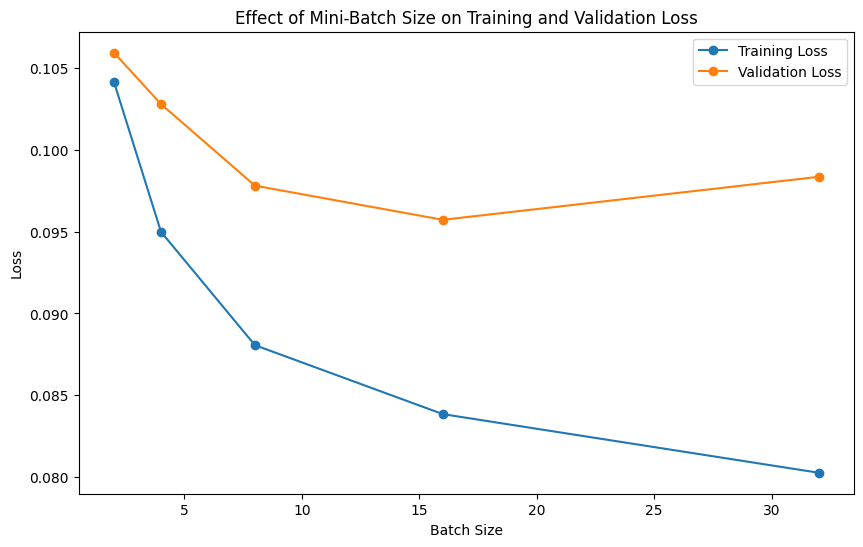

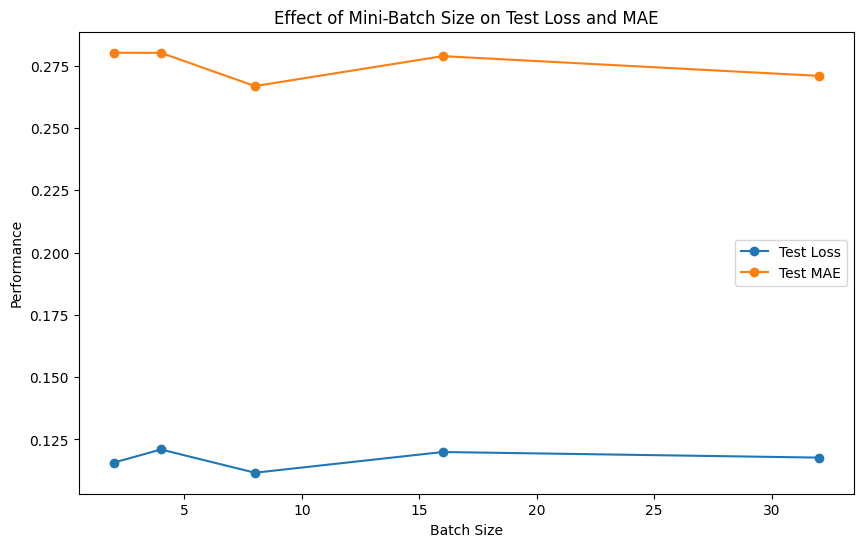

In [ ]:
# plot Validation Loss with batch size
plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['train_loss'], marker='o', label='Training Loss')
plt.plot(results_df['batch_size'], results_df['val_loss'], marker='o', label='Validation Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.title('Effect of Mini-Batch Size on Training and Validation Loss')
plt.legend()
plt.show()

# plot MAE with batch size
plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['test_loss'], marker='o', label='Test Loss')
plt.plot(results_df['batch_size'], results_df['test_mae'], marker='o', label='Test MAE')
plt.xlabel('Batch Size')
plt.ylabel('Performance')
plt.title('Effect of Mini-Batch Size on Test Loss and MAE')
plt.legend()
plt.show()

# 3. Investigate effects of different optimizers

Training with optimizer: SGD


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with optimizer: SGD with Momentum


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with optimizer: Adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with optimizer: RMSprop


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with optimizer: Adagrad


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


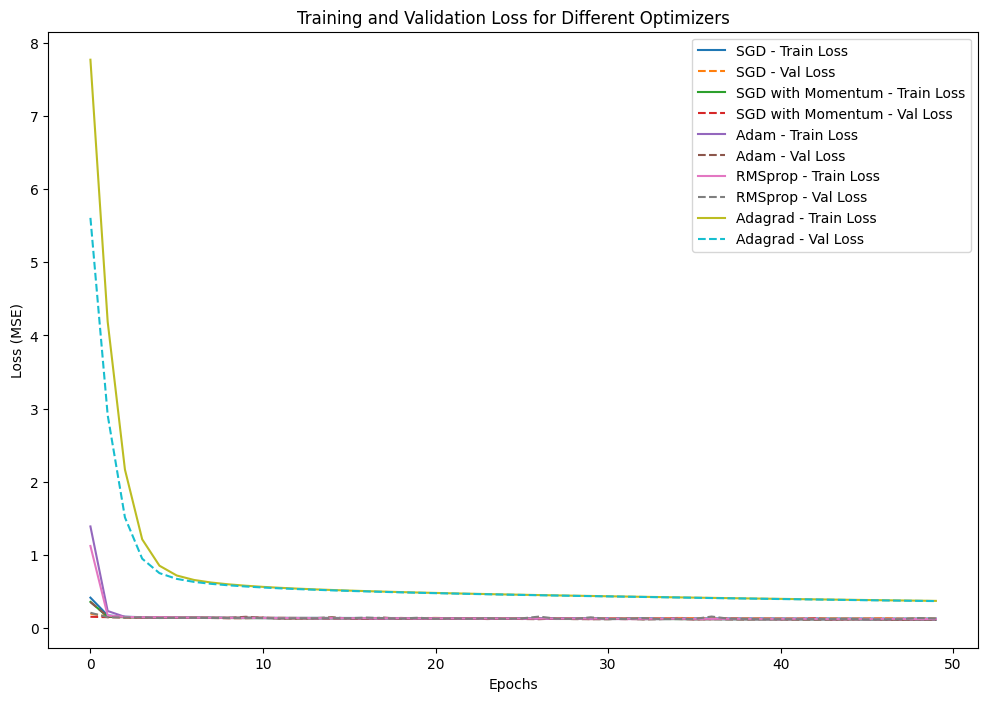

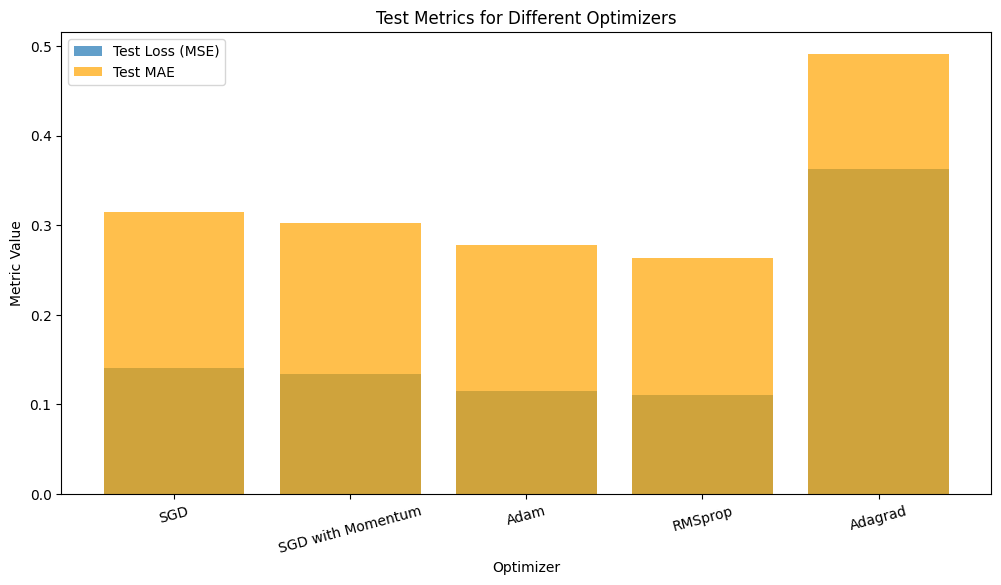

In [ ]:
# Define the optimizers to test
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD with Momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Adam': tf.keras.optimizers.Adam(),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad()
}

optimizer_results = {}

# Train the model with each optimizer
for optimizer_name, optimizer in optimizers.items():
    print(f"Training with optimizer: {optimizer_name}")

    # Reinitialize the model for each optimizer
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)  # Output layer for GPA prediction
    ])

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0  # Suppress detailed output for readability
    )

    # Evaluate on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    # Store results
    optimizer_results[optimizer_name] = {
        'history': history,
        'test_loss': test_loss,
        'test_mae': test_mae
    }

# Visualize training dynamics for different optimizers
plt.figure(figsize=(12, 8))
for optimizer_name in optimizers.keys():
    plt.plot(optimizer_results[optimizer_name]['history'].history['loss'], label=f'{optimizer_name} - Train Loss')
    plt.plot(optimizer_results[optimizer_name]['history'].history['val_loss'], linestyle='--', label=f'{optimizer_name} - Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss for Different Optimizers')
plt.legend()
plt.show()

# Plot final test loss and MAE for each optimizer
optimizer_test_loss = [optimizer_results[opt]['test_loss'] for opt in optimizers.keys()]
optimizer_test_mae = [optimizer_results[opt]['test_mae'] for opt in optimizers.keys()]

plt.figure(figsize=(12, 6))
plt.bar(optimizers.keys(), optimizer_test_loss, alpha=0.7, label='Test Loss (MSE)')
plt.bar(optimizers.keys(), optimizer_test_mae, alpha=0.7, label='Test MAE', color='orange')
plt.xlabel('Optimizer')
plt.ylabel('Metric Value')
plt.title('Test Metrics for Different Optimizers')
plt.xticks(rotation=15)
plt.legend()
plt.show()


# 4. Tune hyperparameters (training testing and validation)

Trial 1 with parameters: {'learning_rate': 0.01, 'batch_size': 16, 'num_layers': 4, 'units': 64, 'dropout_rate': 0.2, 'activation': 'tanh'}
Trial 2 with parameters: {'learning_rate': 0.01, 'batch_size': 64, 'num_layers': 2, 'units': 32, 'dropout_rate': 0.0, 'activation': 'tanh'}
Trial 3 with parameters: {'learning_rate': 0.01, 'batch_size': 16, 'num_layers': 2, 'units': 128, 'dropout_rate': 0.2, 'activation': 'tanh'}
Trial 4 with parameters: {'learning_rate': 0.1, 'batch_size': 16, 'num_layers': 2, 'units': 64, 'dropout_rate': 0.5, 'activation': 'relu'}
Trial 5 with parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'activation': 'tanh'}
Trial 6 with parameters: {'learning_rate': 0.1, 'batch_size': 32, 'num_layers': 2, 'units': 32, 'dropout_rate': 0.5, 'activation': 'relu'}
Trial 7 with parameters: {'learning_rate': 0.001, 'batch_size': 16, 'num_layers': 4, 'units': 128, 'dropout_rate': 0.2, 'activation': 'tanh'}
Trial 8 with param

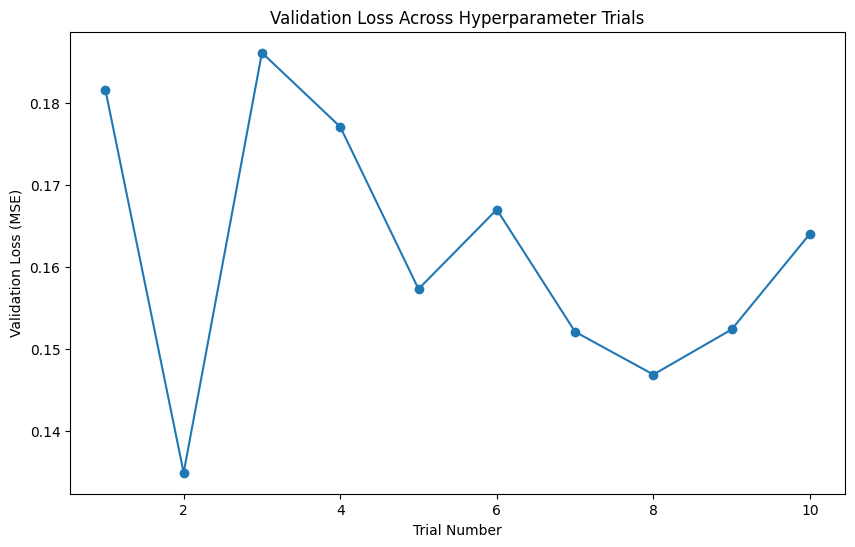

In [ ]:
# Define the hyperparameter search space
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'num_layers': [2, 3, 4],
    'units': [32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.5],
    'activation': ['relu', 'tanh']
}

# Randomly sample hyperparameter combinations
num_trials = 10
results = []

for trial in range(num_trials):
    # Randomly sample hyperparameters
    params = {key: random.choice(values) for key, values in param_grid.items()}
    print(f"Trial {trial + 1} with parameters: {params}")

    # Build the model with sampled parameters
    model = tf.keras.Sequential()
    for _ in range(params['num_layers']):
        model.add(tf.keras.layers.Dense(params['units'], activation=params['activation']))
        if params['dropout_rate'] > 0:
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))
    model.add(tf.keras.layers.Dense(1))  # Output layer for GPA prediction

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,  # Use fewer epochs for faster experimentation
        batch_size=params['batch_size'],
        verbose=0
    )

    # Evaluate the model on the validation set
    val_loss = history.history['val_loss'][-1]
    val_mae = history.history['val_mae'][-1]

    # Store results
    results.append({
        'params': params,
        'val_loss': val_loss,
        'val_mae': val_mae
    })

# Find the best hyperparameters based on validation loss
best_result = min(results, key=lambda x: x['val_loss'])
best_params = best_result['params']

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Visualize validation loss for each trial
val_losses = [res['val_loss'] for res in results]
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_trials + 1), val_losses, marker='o')
plt.xlabel('Trial Number')
plt.ylabel('Validation Loss (MSE)')
plt.title('Validation Loss Across Hyperparameter Trials')
plt.show()


**Analysis of Results**
1. Learning Rate:

The learning rate significantly influenced the model's stability and convergence. A learning rate of 0.01 consistently produced stable training and a better balance between learning speed and avoiding overshooting. This suggests that the step size of gradient updates was optimal, allowing the model to converge effectively without oscillating around the loss minima. In contrast, a higher learning rate of 0.1 led to unstable training dynamics and worse validation loss (e.g., Trials 6, 8, 9). This is likely because larger learning rates cause gradient updates to overshoot the optimal solution, making it difficult for the model to converge.
2. Batch Size:

Smaller batch sizes, particularly 16, provided better generalization as seen in Trials 4 and 7. This is because smaller batch sizes introduce stochasticity in the gradient updates, which can help escape local minima and find a better generalization solution for noisy data.Larger batch sizes (32 and 64) resulted in smoother gradients but at the cost of reduced generalization, likely because the gradients are averaged over more data, making it harder to adapt to nuances in the data distribution. This aligns with the general observation that smaller batch sizes are often better for tasks where generalization is critical.
3. Number of Layers:

Simpler architectures with 2 layers outperformed deeper architectures (e.g., Trials 1 and 7). This suggests that the dataset complexity and available features did not require highly complex models to effectively learn the mapping between input and output. Increasing the number of layers to 4 (e.g., Trials 5 and 10) caused worse validation loss, likely due to overfitting or difficulty in optimization. Deep networks require more data and careful regularization, which may not have been available or optimal in this case.
4. Units per Layer:

64 units per layer struck a good balance between model capacity and training performance. This configuration allowed the model to capture the necessary complexity of the data without overfitting (e.g., Trials 3 and 7).Increasing the units to 128 (e.g., Trials 1, 2, 4) added unnecessary complexity. While this increased the model's capacity, it did not significantly improve performance, indicating that the dataset did not require such high-dimensional feature representations.
5. Dropout Rate:

A dropout rate of 0.0 was the most effective configuration. This suggests that overfitting was not a major concern for this dataset and that regularization via dropout may have unnecessarily reduced the model's learning capacity (e.g., Trials 5 and 10 with dropout rates of 0.5). Higher dropout rates led to degraded performance, likely because important patterns in the data were "dropped" during training, resulting in underutilization of the model's full capacity.
6. Activation Function:

The tanh activation function consistently outperformed relu in terms of validation loss (e.g., Trials 7 and 10). The bounded nature of tanh ensures that activations remain within a range of -1 to 1, stabilizing the gradient flow and reducing the risk of exploding gradients. On the other hand, relu may have suffered from the "dying neuron" problem, where neurons output constant values due to negative inputs. This could explain the suboptimal performance in trials where relu was used, especially in deeper architectures.


**Additional work**
To further analyze the impact of feature selection and compare model performance, we conducted an additional experiment where the input features were limited to only time (e.g., Year ) and course number. This streamlined approach reduces the complexity of the input data and focuses on understanding how temporal and course-specific patterns influence GPA predictions.

For this purpose, an RNN (Recurrent Neural Network) model was built, as RNNs are well-suited for capturing sequential or temporal dependencies in data. This design choice was made to investigate whether time-based trends or patterns in course numbers significantly contribute to predicting the target variable (GPA). The compared network can be found:
https://drive.google.com/file/d/13NZGgzGp0-Fzm9zoLwxtHcIuxOo1I3nE/view?usp=sharing